In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv('Train_set.csv', index_col='_id')
df.head()

,Disease,Year,PROVINCE,Week_no,Count
_id,,,,,
1,Hand Foot Mouth,2013,Bangkok,1,62.0
2,Hand Foot Mouth,2013,Bangkok,2,95.0
3,Hand Foot Mouth,2013,Bangkok,3,88.0
4,Hand Foot Mouth,2013,Bangkok,4,86.0
5,Hand Foot Mouth,2013,Bangkok,5,132.0


### Overview

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40194 entries, 1 to 40194
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Disease   40194 non-null  object 
 1   Year      40194 non-null  int64  
 2   PROVINCE  40194 non-null  object 
 3   Week_no   40194 non-null  int64  
 4   Count     40194 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [45]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + (df['Week_no'] - 1).astype(str) + '2', format='%Y%W%w')
df.set_index('Date', inplace=True)
df

,Disease,Year,PROVINCE,Week_no,Count
Date,,,,,
2013-01-01,Hand Foot Mouth,2013,Bangkok,1,62.0
2013-01-08,Hand Foot Mouth,2013,Bangkok,2,95.0
2013-01-15,Hand Foot Mouth,2013,Bangkok,3,88.0
2013-01-22,Hand Foot Mouth,2013,Bangkok,4,86.0
2013-01-29,Hand Foot Mouth,2013,Bangkok,5,132.0
...,...,...,...,...,...
2022-11-22,Hand Foot Mouth,2022,Narathiwat,48,13.0
2022-11-29,Hand Foot Mouth,2022,Narathiwat,49,11.0
2022-12-06,Hand Foot Mouth,2022,Narathiwat,50,6.0


In [46]:
df = df.sort_values(['Year', 'Week_no', 'Count'])
df.drop(columns=['Disease', 'Year'], inplace=True)
df

,PROVINCE,Week_no,Count
Date,,,
2013-01-01,Maha Sarakham,1,1.0
2013-01-01,Chiang Mai,1,1.0
2013-01-01,Nan,1,1.0
2013-01-01,Satun,1,1.0
2013-01-01,Chaiyaphum,1,2.0
...,...,...,...
2022-12-20,Ubon Ratchathani,52,19.0
2022-12-20,Surat Thani,52,19.0
2022-12-20,Chanthaburi,52,21.0


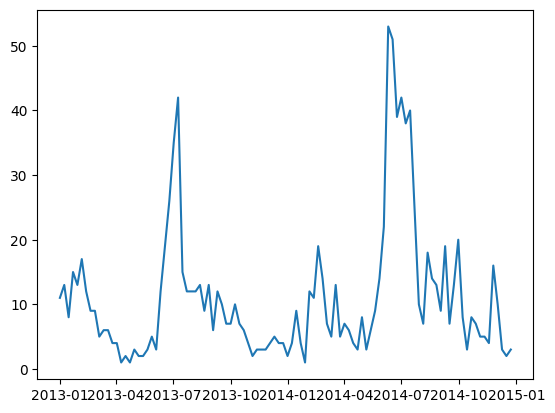

In [47]:
slice = df[(df.index >= '2013-01-01') & (df.index <= '2014-12-31') & (df['PROVINCE'] == 'Nonthaburi')]
plt.plot(slice.index, slice['Count'])

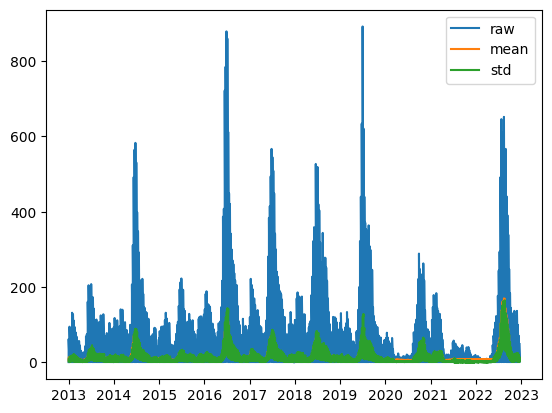

In [48]:
def check_stationary(df, label):
    temp_df = df.copy()
    temp_df['roll_mean'] = temp_df[label].rolling(52).mean()
    temp_df['roll_std'] = temp_df[label].rolling(52).std()

    plt.plot(temp_df.index, temp_df[label], label='raw')
    plt.plot(temp_df.index, temp_df['roll_mean'], label='mean')
    plt.plot(temp_df.index, temp_df['roll_std'], label='std')

    plt.legend()
    
check_stationary(df, 'Count')

### Feature Engineering

In [9]:
from sklearn.preprocessing import LabelEncoder

In [65]:
df_prep = df[df.index > '2021-12-31'].copy()

# clean 0 for log testing
log_clean = [ x + 1 if x == 0 else x for x in df_prep['Count'].values ]

encode = LabelEncoder()
df_prep['provinceID'] = encode.fit_transform(df_prep['PROVINCE'])
df_prep

,PROVINCE,Week_no,Count,provinceID
Date,,,,
2022-01-04,Samut Prakan,2,1.0,56
2022-01-04,Pathum Thani,2,1.0,36
2022-01-04,Ang Thong,2,1.0,1
2022-01-04,Lopburi,2,1.0,21
2022-01-04,Saraburi,2,1.0,59
...,...,...,...,...
2022-12-20,Ubon Ratchathani,52,19.0,71
2022-12-20,Surat Thani,52,19.0,66
2022-12-20,Chanthaburi,52,21.0,8


In [66]:
def lag_province_diff(df, label, lag=4):
    temp = pd.DataFrame(columns=df.columns, index=df.index)
    temp[f'lag{lag}_diff'] = 0
    temp.dropna(inplace=True)
    for province in df['PROVINCE'].unique():
        province_df = df[ df['PROVINCE'] == province ].copy()
        province_df[f'lag{lag}_diff'] = df[ df['PROVINCE'] == province ][label].diff(lag)
        temp = pd.concat([temp, province_df])
        
    return temp

df_prep = lag_province_diff(df_prep, 'Count', lag=4)
df_prep = lag_province_diff(df_prep, 'Count', lag=8)
df_prep = lag_province_diff(df_prep, 'Count', lag=12)
df_prep

C:\Users\ACER\AppData\Local\Temp\ipykernel_18340\3697179531.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp = pd.concat([temp, province_df])
C:\Users\ACER\AppData\Local\Temp\ipykernel_18340\3697179531.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp = pd.concat([temp, province_df])
C:\Users\ACER\AppData\Local\Temp\ipykernel_18340\3697179531.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no l

,PROVINCE,Week_no,Count,provinceID,lag4_diff,lag8_diff,lag12_diff
Date,,,,,,,
2022-01-04,Samut Prakan,2,1.0,56,NaN,NaN,NaN
2022-01-11,Samut Prakan,3,8.0,56,NaN,NaN,NaN
2022-01-18,Samut Prakan,4,1.0,56,NaN,NaN,NaN
2022-01-25,Samut Prakan,5,2.0,56,NaN,NaN,NaN
2022-02-01,Samut Prakan,6,1.0,56,0.0,NaN,NaN
...,...,...,...,...,...,...,...
2022-11-22,Chiang Rai,48,112.0,10,59.0,15.0,12.0
2022-11-29,Chiang Rai,49,93.0,10,20.0,-2.0,8.0
2022-12-06,Chiang Rai,50,99.0,10,3.0,29.0,-14.0


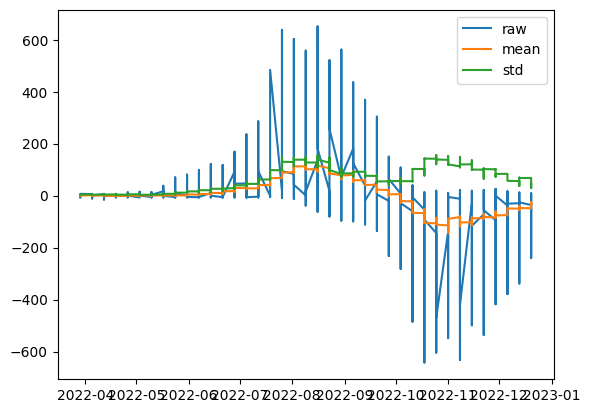

In [52]:
check_stationary(df_prep.sort_values(['Date']), 'lag12_diff')

In [53]:
from statsmodels.tsa.stattools import adfuller

adf_score = adfuller(df_prep['lag12_diff'].dropna(), autolag='AIC')
stats = pd.Series(adf_score[0:4], index=['Test statistics', 'p-value', '#lag-used', 'number of observations used'])
stats

Test statistics               -1.551071e+01
p-value                        2.350598e-28
#lag-used                      2.800000e+01
number of observations used    2.974000e+03
dtype: float64

In [54]:
for key, value in adf_score[4].items():
    print(f'confidence interval {key}:  {value}')

confidence interval 1%:  -3.4325507240185105
confidence interval 5%:  -2.862512336314338
confidence interval 10%:  -2.5672876007125645


### SARIMAX

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

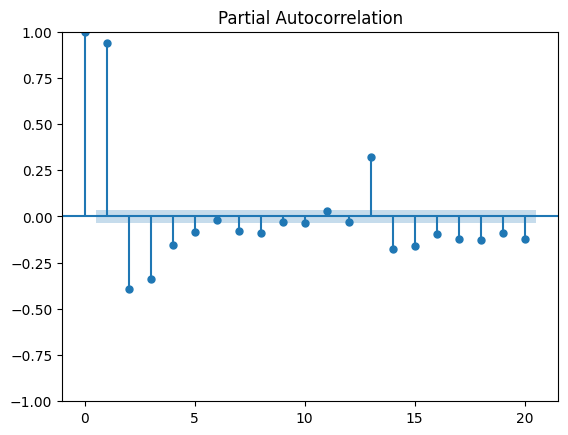

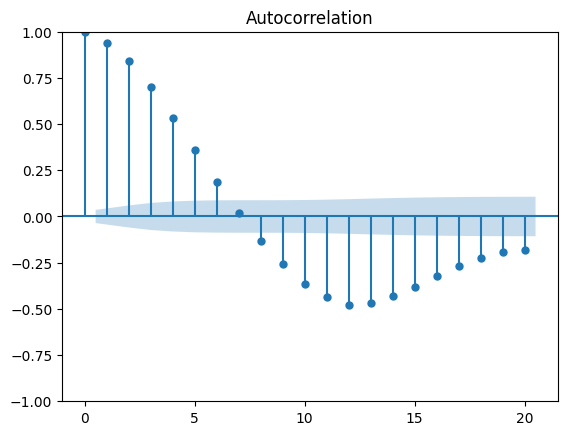

In [16]:
pacf = plot_pacf(df_prep['lag12_diff'].dropna(), lags=20) # p
acf = plot_acf(df_prep['lag12_diff'].dropna(), lags=20)  # q

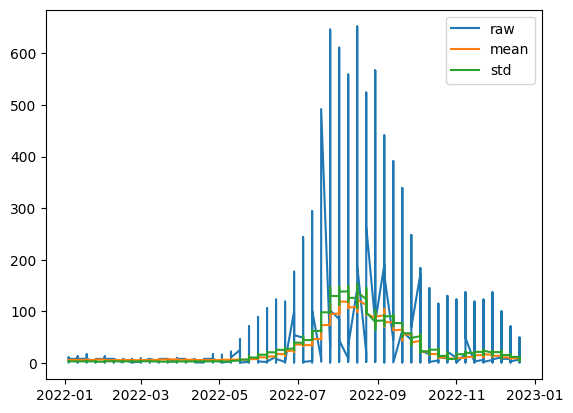

In [17]:
check_stationary(df_prep.sort_values(['Date']), 'Count')

In [18]:
model = SARIMAX(df_prep['Count'].values, exog=df_prep['provinceID'].values,
                order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3927
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood              -17923.976
Date:                            Mon, 16 Sep 2024   AIC                          35855.951
Time:                                    06:13:09   BIC                          35881.040
Sample:                                         0   HQIC                         35864.854
                                           - 3927                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0008      0.113      0.007      0.995      -0.220       0.222
ar.L1          0.3280      0.006     59.403      0.000       0.317       0.339
ar.S.L12      -0.5087      0.005    -97.137      0.000      -0.519      -0.498
sigma2       555.6128      3.923    141.624      0.000     547.924     563.302
===================================================================================
Ljung-Box (L1) (Q):                  27.82   Jarque-Bera (JB):             55989.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### LSTM

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [115]:
lstm_df = df_prep.sort_values(['Date', 'provinceID']).copy()
lstm_df.drop(columns=['PROVINCE', 'Week_no'], inplace=True)
lstm_df.dropna(inplace=True)

lstm_df['provinceID'] = lstm_df['provinceID'].astype('int')
lstm_df

,Count,provinceID,lag4_diff,lag8_diff,lag12_diff
Date,,,,,
2022-03-29,8.0,0,0.0,0.0,0.0
2022-03-29,8.0,1,0.0,0.0,7.0
2022-03-29,10.0,2,1.0,6.0,3.0
2022-03-29,8.0,3,0.0,0.0,0.0
2022-03-29,8.0,4,7.0,7.0,0.0
...,...,...,...,...,...
2022-12-20,8.0,72,0.0,0.0,0.0
2022-12-20,1.0,73,-7.0,-2.0,-18.0
2022-12-20,4.0,74,3.0,2.0,-18.0


In [116]:
train, valid = np.split(lstm_df, [int(len(lstm_df)*0.8)])
train_date, valid_date = train.index, valid.index

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

X_train, y_train = train.drop(columns=['Count']), train['Count']
X_valid, y_valid = valid.drop(columns=['Count']), valid['Count']

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [117]:
model = Sequential([
    layers.Input((3, 1)), 
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=200)

Epoch 1/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8438.8457 - mean_absolute_error: 41.4064 - val_loss: 231.6830 - val_mean_absolute_error: 7.0003
Epoch 2/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4693.3584 - mean_absolute_error: 24.1871 - val_loss: 223.5324 - val_mean_absolute_error: 7.8004
Epoch 3/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 945.7783 - mean_absolute_error: 9.6450 - val_loss: 217.3424 - val_mean_absolute_error: 7.2752
Epoch 4/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 578.1994 - mean_absolute_error: 8.3413 - val_loss: 205.6665 - val_mean_absolute_error: 6.8384
Epoch 5/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 242.1486 - mean_absolute_error: 6.4808 - val_loss: 195.2775 - val_mean_absolute_error: 7.0004
Epoch 6/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 173.6688 - mean_absolute_error: 6.2967 - val_loss: 205.5957 - val_mean_absolute_error: 6.4839
Epoch 7/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178.0446 - mean_abs

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


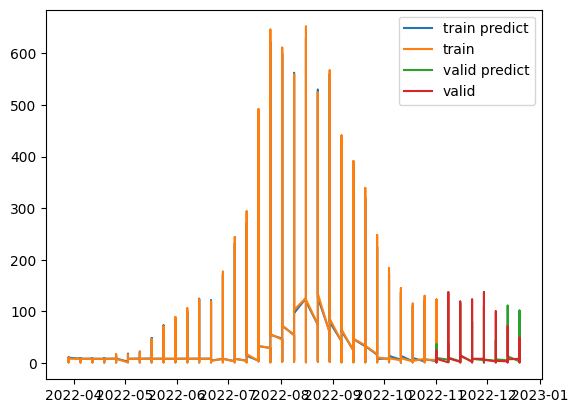

In [118]:
def plot_predictions(model):
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    # plot all of predictions with the observations
    plt.plot(train_date, train_pred, label='train predict')
    plt.plot(train_date, y_train, label='train')

    plt.plot(valid_date, valid_pred, label='valid predict')
    plt.plot(valid_date, y_valid, label='valid')

    plt.legend()
    

plot_predictions(model)

### Test Prediction

In [119]:
test_df = pd.read_csv('Test_set.csv', index_col='_id')
test_df['provinceID'] = encode.fit_transform(test_df['PROVINCE']).astype('int')
test_df.drop(columns=['Disease'], inplace=True)

test_df['Count'] = 0
test_df

,Year,PROVINCE,Week_no,provinceID,Count
_id,,,,,
40195,2023,Bangkok,1,2,0
40196,2023,Bangkok,2,2,0
40197,2023,Bangkok,3,2,0
40198,2023,Bangkok,4,2,0
40199,2023,Bangkok,5,2,0
...,...,...,...,...,...
43385,2023,Narathiwat,37,32,0
43386,2023,Narathiwat,38,32,0
43387,2023,Narathiwat,39,32,0


In [120]:
predicted_df = df_prep.drop(columns=['PROVINCE', 'Count'])
predicted_df = predicted_df.sort_values(['provinceID', 'Week_no'])
predicted_df.bfill(inplace=True)
predicted_df['Predict'] = model.predict(predicted_df.drop(columns='Week_no')).astype('int')
predicted_df

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


,Week_no,provinceID,lag4_diff,lag8_diff,lag12_diff,Predict
Date,,,,,,
2022-01-04,2,0,0.0,0.0,0.0,8
2022-01-11,3,0,0.0,0.0,0.0,8
2022-01-18,4,0,0.0,0.0,0.0,8
2022-01-25,5,0,0.0,0.0,0.0,8
2022-02-01,6,0,0.0,0.0,0.0,8
...,...,...,...,...,...,...
2022-11-22,48,76,2.0,-3.0,-78.0,7
2022-11-29,49,76,-2.0,-3.0,-59.0,6
2022-12-06,50,76,-5.0,-5.0,-43.0,6


In [121]:
predicted_df = predicted_df.sample(3195).sort_values(['provinceID', 'Week_no'])
predicted_df.shape

(3195, 6)

In [123]:
test_df = test_df.sort_values(['provinceID', 'Week_no'])
test_df['Count'] = predicted_df['Predict'].values
test_df

,Year,PROVINCE,Week_no,provinceID,Count
_id,,,,,
41230,2023,Amnat Charoen,1,0,8
41231,2023,Amnat Charoen,2,0,8
41232,2023,Amnat Charoen,3,0,8
41233,2023,Amnat Charoen,4,0,8
41234,2023,Amnat Charoen,5,0,8
...,...,...,...,...,...
41184,2023,Yasothon,38,76,13
41185,2023,Yasothon,39,76,6
41186,2023,Yasothon,40,76,6


In [124]:
test_df = test_df.sort_index()
test_df = test_df[['Count']]
test_df = test_df.rename(columns={'Count': 'Pred'})
test_df

,Pred
_id,
40195,3
40196,2
40197,2
40198,2
40199,3
...,...
43385,6
43386,3
43387,6


In [125]:
test_df.to_csv('submission.csv')